In [ ]:
# 라이브러리 임포트
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
# 딥러닝 라이브러리 임포트
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Tabular traindata.csv 불러오기
# df = pd.read_csv('full_data_training.csv')

df = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/brain_stroke_data_training.csv')
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [ ]:
# Tabular 데이터 정보 확인
# 위의 df와 비교하면서 값하고 Dtype이 다른 부분이 있는지 확인
# 결측치 확인, 데이터 컬럼의 용도 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [ ]:
# Tabular 데이터 전처리 - 라벨 인코딩
df['gender'] = np.where(df['gender']=='Male', 1, 0)
df['ever_married'] = np.where(df['ever_married']=='Yes', 1, 0)

In [ ]:
# Tabular 데이터 전처리 - 결측치 확인
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [ ]:
# Tabular 데이터 전처리 - 원 핫 인코딩, object인 데이터만 분류
obj_col = df.select_dtypes('object').columns
obj_col

Index(['work_type', 'Residence_type', 'smoking_status'], dtype='object')

In [ ]:
# Tabular 데이터 전처리 - 원 핫 인코딩
df = pd.get_dummies(data=df, columns=obj_col, drop_first=True)

In [ ]:
# Tabular 데이터 컬럼 변경사항 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          4981 non-null   int64  
 1   age                             4981 non-null   float64
 2   hypertension                    4981 non-null   int64  
 3   heart_disease                   4981 non-null   int64  
 4   ever_married                    4981 non-null   int64  
 5   avg_glucose_level               4981 non-null   float64
 6   bmi                             4981 non-null   float64
 7   stroke                          4981 non-null   int64  
 8   work_type_Private               4981 non-null   bool   
 9   work_type_Self-employed         4981 non-null   bool   
 10  work_type_children              4981 non-null   bool   
 11  Residence_type_Urban            4981 non-null   bool   
 12  smoking_status_formerly smoked  49

In [ ]:
# Tabular 데이터 feature, label 분류
features = df.drop('stroke', axis=1)
labels = df['stroke']

In [ ]:
#label
labels.value_counts()

,count
stroke,
0,4733
1,248


In [ ]:
# Tabular 데이터 Train, valid 데이터셋 분할
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((3984, 14), (997, 14), (3984,), (997,))

In [ ]:
# 라이브러리 임포트
"""
머신러닝 분류 모델의 경우 아래의 것들이 성능이 좋았어서 이것들만 사용했습니다.
LogisticRegression 이 연산 속도가 빨라서 먼저 실행해보고서 어느정도의 성능이 나오는지 보고
성능이 부족한거 같으면 RandomForestClassifier와 DecisionTreeClassifier를 사용했습니다.
딥러닝 분류 모델도 만들어서 모델 성능을 비교하고 마지막에 골라서 제출했습니다.
머신러닝 회귀 모델의 경우 DecisionTreeRegressor, RandomForestRegressor, 딥러닝 CNN 모델만 사용했습니다.
"""
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Tabular LogisticRegression 머신러닝 모델 분류 성능 확인
lgr = LogisticRegression()
lgr.fit(x_train, y_train)
lgr.score(x_valid, y_valid)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9498495486459378

In [ ]:
# Tabular SGDClassifier 머신러닝 모델 분류 성능 확인
sgdc = SGDClassifier()
sgdc.fit(x_train, y_train)
sgdc.score(x_valid, y_valid)

0.9498495486459378

In [ ]:
# Tabular DecisionTreeClassifier 머신러닝 모델 분류 성능 확인
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc.score(x_valid, y_valid)

0.9087261785356068

In [ ]:
# Tabular RandomForestClassifier 머신러닝 모델 분류 성능 확인
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc.score(x_valid, y_valid)

0.9498495486459378

In [ ]:
# Tabular 딥러닝 모델
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train.shape[-1], )))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax')) #저는 2개 분류~여러개 분류 모두 softmax로 통일해서 사용했습니다.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Tabular 딥러닝 모델 compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Tabular 딥러닝 모델 훈련 fit
# Tabular는 es, mc, history에 숫자를 붙이지 않고 사용했습니다.
# 같은 코드 안에서 3개의 모델을 만들어서 비슷한 변수명에 숫자나, text, img를 붙였습니다.

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_valid, y_valid),
    callbacks=[es, mc],
    verbose=1
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5386 - loss: 0.8668
Epoch 1: val_loss improved from inf to 0.52595, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5395 - loss: 0.8652 - val_accuracy: 0.8766 - val_loss: 0.5259
Epoch 2/10
121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8967 - loss: 0.3584
Epoch 2: val_loss improved from 0.52595 to 0.33124, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8974 - loss: 0.3568 - val_accuracy: 0.9208 - val_loss: 0.3312
Epoch 3/10
113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9371 - loss: 0.2557
Epoch 3: val_loss improved from 0.33124 to 0.20192, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9376 - loss: 0.2537 - val_accuracy: 0.9498 - val_loss: 0.2019
Epoch 4/10
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9491 - loss: 0.2050
Epoch 4: val_loss improved from 0.20192 to 0.18486,

In [ ]:
# Tabular test 데이터셋.csv 읽기
#df5 = pd.read_csv('full_data_validation.csv')

df5 = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/brain_stroke_data_validation.csv')
df5

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,31.555602,never smoked,1
1,Female,59.0,0,0,Yes,Private,Rural,76.15,30.242937,Unknown,1
2,Male,78.0,0,1,Yes,Private,Urban,219.84,30.698951,Unknown,1
3,Male,57.0,0,1,No,Govt_job,Urban,217.08,33.808410,Unknown,1
4,Male,58.0,0,0,Yes,Private,Rural,189.84,31.378534,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
196,Male,41.0,0,0,No,Private,Rural,70.15,29.756631,formerly smoked,0
197,Male,40.0,0,0,Yes,Private,Urban,191.15,31.124172,smokes,0
198,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.798304,smokes,0
199,Male,40.0,0,0,Yes,Private,Rural,83.94,29.951301,smokes,0


In [ ]:
"""
위의 train, valid 데이터와 동일하게 대부분 데이터 전처리를 수행합니다.
훈련 데이터 셋에서는 중복, 결측치를 제거해서 모델의 분류 성능을 올려야 하지만,
테스트 데이터셋의 갯수를 줄이는 것은 (중복 삭제, 결측치 제거)는 하면 안됩니다.
무의식적으로 하다가 지운 경우가 많았던거 같습니다.
"""
# Tabular test 데이터 전처리 - 라벨 인코딩
df5['gender'] = np.where(df5['gender']=='Male', 1, 0)
df5['ever_married'] = np.where(df5['ever_married']=='Yes', 1, 0)
df5.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [ ]:
# Tabular Test 데이터 전처리 - 원 핫 인코딩
obj_col2 = df5.select_dtypes('object').columns
df5 = pd.get_dummies(data=df5, columns=obj_col2, drop_first=True)

In [ ]:
# Tabular Test 데이터 feature, label 분류
x_test = df5.drop('stroke', axis=1)
y_test = df5['stroke']

In [ ]:
# Tabular Test 데이터로 머신러닝, 딥러닝 모델 성능 예측
lgr_y_pred = lgr.predict(x_test)
sgdc_y_pred = sgdc.predict(x_test)
dtc_y_pred = dtc.predict(x_test)
rfc_y_pred = rfc.predict(x_test)
model_y_pred = model.predict(x_test)
model_y_pred = np.argmax(model_y_pred, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


In [ ]:
"""
LogisticRegression 훈련 데이터셋 성능: 0.9498 (95%)
SGDClassifier 훈련 데이터셋 성능: 0.9498 (95%)
DecisionTreeClassifier 훈련 데이터셋 성능: 0.9067 (91%)
RandomForestClassifier 훈련 데이터셋 성능: 0.9478 (95%)
딥러닝 모델 훈련 데이터셋 성능: 0.9498 (95%)


"""

In [ ]:
# Tabular 데이터 분류 시각화
from sklearn.metrics import classification_report, confusion_matrix

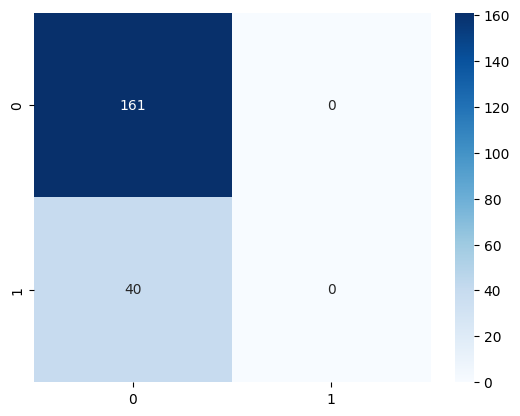

In [ ]:
# Logistic Regression 모델 성능 - 모델이 다 0을 예측해서 좋은거처럼 보였던거 같네요
cm = confusion_matrix(y_test, lgr_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

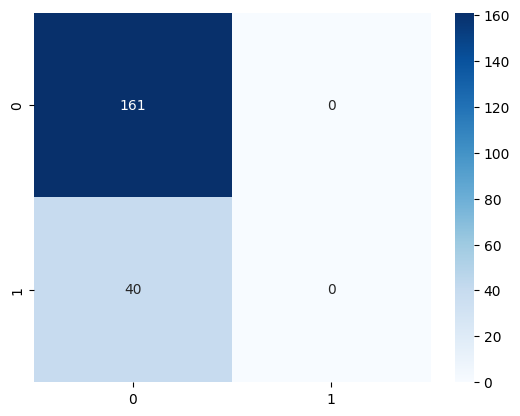

In [ ]:
# SGDC Classifier 모델 성능 - 훈련이 잘못된거 같아요.
cm = confusion_matrix(y_test, sgdc_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

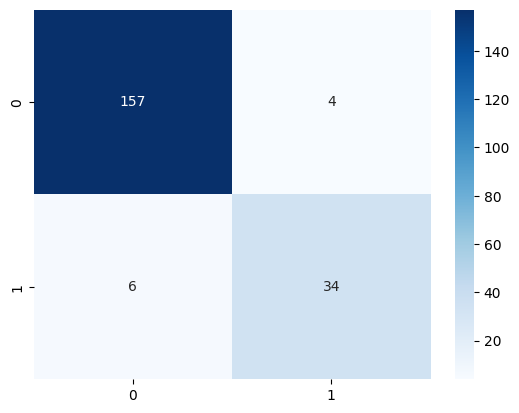

In [ ]:
# DecisionTreeClassifier 모델 성능 - 오 분류 성능이 꽤 좋아보입니다.
cm = confusion_matrix(y_test, dtc_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

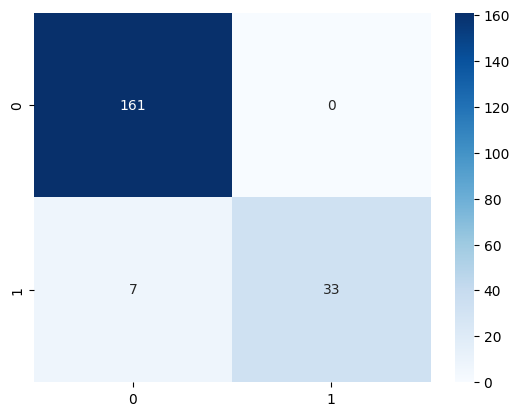

In [ ]:
# RandomForestClassifier 모델 성능 - 오 분류 성능이 꽤 좋아보입니다. DecisionTree와 비슷한 성능인거 같네요.
cm = confusion_matrix(y_test, rfc_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

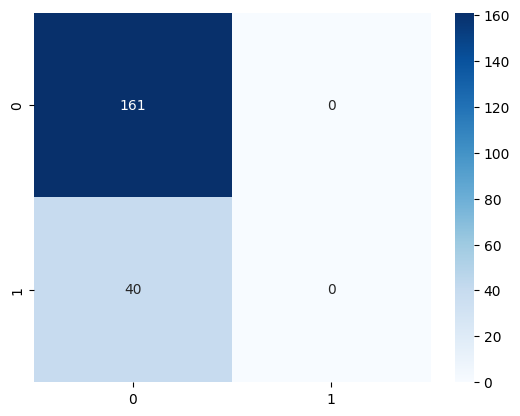

In [ ]:
# 딥러닝 모델 성능 - 모델이 다 0을 예측해서 좋은거처럼 보였던거 같네요
cm = confusion_matrix(y_test, model_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# 모델중에 가장 성능이 좋아보이는 DecisionTreeClassifier의 예측값을 테스트 데이터셋 csv에 추가
df5['pred'] = rfc_y_pred
df5

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,pred
0,0,61.0,0,0,1,202.21,31.555602,1,False,True,False,False,False,True,False,0
1,0,59.0,0,0,1,76.15,30.242937,1,True,False,False,False,False,False,False,1
2,1,78.0,0,1,1,219.84,30.698951,1,True,False,False,True,False,False,False,1
3,1,57.0,0,1,0,217.08,33.808410,1,False,False,False,True,False,False,False,0
4,1,58.0,0,0,1,189.84,31.378534,1,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1,41.0,0,0,0,70.15,29.756631,0,True,False,False,False,True,False,False,0
197,1,40.0,0,0,1,191.15,31.124172,0,True,False,False,True,False,False,True,0
198,0,45.0,1,0,1,95.02,31.798304,0,False,False,False,False,False,False,True,0
199,1,40.0,0,0,1,83.94,29.951301,0,True,False,False,False,False,False,True,0


In [ ]:
# 테스트 데이터셋 모델 성능 확인 - 안해도 되는 작업이지만 라벨이 있어서 한번 더 확인해봤습니다.
correct_count = sum(df5['stroke']==df5['pred'])
total_count = len(df5)
model_accuracy = correct_count/total_count
print(f'model_accuracy : {model_accuracy:.2f}')

model_accuracy : 0.97


In [ ]:
# Tabular 머신러닝 모델 저장을 위한 joblib 라이브러리 임포트
import joblib
joblib.dump(rfc, 'model1.joblib')

['01012345678_1.joblib']

In [ ]:
# Tabular 모델 저장 확인
tab_load_model = joblib.load('model1.joblib')

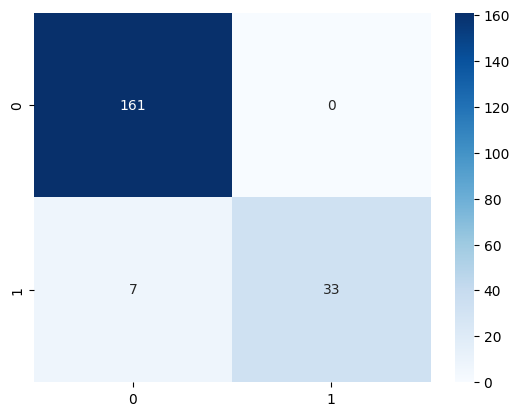

In [ ]:
# Tabular 모델 불러와서 모델 성능 확인 / 불필요
tab_load_y_pred = tab_load_model.predict(x_test)
cm = confusion_matrix(y_test, tab_load_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# Tabular 모델 테스트 데이터셋.csv 저장
df5.to_csv('result1.csv', index=False, encoding='utf-8') # Tabular 데이터는 '연락처_1.csv' 으로 저장
df6 = pd.read_csv('result1.csv') # 데이터 저장 확인
df6

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,pred
0,0,61.0,0,0,1,202.21,31.555602,1,False,True,False,False,False,True,False,0
1,0,59.0,0,0,1,76.15,30.242937,1,True,False,False,False,False,False,False,1
2,1,78.0,0,1,1,219.84,30.698951,1,True,False,False,True,False,False,False,1
3,1,57.0,0,1,0,217.08,33.808410,1,False,False,False,True,False,False,False,0
4,1,58.0,0,0,1,189.84,31.378534,1,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1,41.0,0,0,0,70.15,29.756631,0,True,False,False,False,True,False,False,0
197,1,40.0,0,0,1,191.15,31.124172,0,True,False,False,True,False,False,True,0
198,0,45.0,1,0,1,95.02,31.798304,0,False,False,False,False,False,False,True,0
199,1,40.0,0,0,1,83.94,29.951301,0,True,False,False,False,False,False,True,0
